In [3]:
# ---- Parameters ----
SCREEN = "20250216_AWALS37_Full_screen_n96"
ANALYSIS = "multiclass_loocv"
MARKER = "all"
ANTIBODY = ["HSP70/SOD1", "FUS/EEA1", "COX IV/Galectin3/atubulin"]

In [4]:
import json
import pickle
import pandas as pd
from pathlib import Path
from maps.screens import ImageScreenMultiAntibody

# --- Initialize parameters ---
pdir = Path("/home/kkumbier/maps/template_analyses/pipelines/params")
with open(pdir / f"{ANALYSIS}.json", "r") as f:
    params = json.load(f)

params["screen"] = SCREEN

# initialize key mapping cell lines to mutations
screen = ImageScreenMultiAntibody(params)
plate_dirs = screen.loader._get_plate_dirs()
metadata = screen.loader.load_metadata(plate_dirs[0])
cellline_to_mutation = dict(zip(metadata["CellLines"], metadata["Mutations"]))

# load in analysis results
output_dir = Path(params.get("result_dir")) / params.get("screen")
ab_str = "_".join(ANTIBODY).replace("/", "-")
with open(output_dir / f"{ANALYSIS}-{ab_str}-{MARKER}.pkl", "rb") as f:
    results = pickle.load(f)

map_analysis = results["analysis"]

# load in cell line metadata
mdir = Path("/awlab/projects/2024_ALS/data/cell_lines")
metadata = pd.read_csv(mdir / "FibroblastCellLine_cleaned.csv")
cellline_to_age = metadata.set_index("CellLines")["AgeOfBiopsy"].to_dict()

## Prepare Data in Standard Format

Convert the predictions to the standard format required by plotting functions:
- `CellLines`: cell line name
- `True`: true class label (integer)
- `Class_0`, `Class_1`, ..., `Class_k`: class probabilities

In [5]:
# Extract predictions and convert to standard format
# Check if fitted is a dictionary with keys (for multi-genetic-background models)
if isinstance(map_analysis.fitted, dict) and "predicted" not in map_analysis.fitted:
    # Get the first key's predictions
    first_key = list(map_analysis.fitted.keys())[0]
    predictions_raw = map_analysis.fitted[first_key]["predicted"].to_pandas()
    print(f"Using predictions from genetic background: {first_key}")
else:
    predictions_raw = map_analysis.fitted["predicted"].to_pandas()

# Check what columns we have
print("Available columns:", predictions_raw.columns.tolist())

# Group by cell line to get average predictions
predictions = (
    predictions_raw.groupby("CellLines")
    .mean()
    .reset_index()
)

# Get the response map to understand class indices
map_response = params["analysis"]["MAP"]["data_loader"]["response_map"]
if "sporadic" in map_response["Mutations"]:
    map_response["Mutations"].pop("sporadic")

class_name_map = {v: k for k, v in map_response["Mutations"].items()}

print("\nStandard format predictions:")
print(predictions.head())
print(f"\nShape: {predictions.shape}")
print(f"\nClass name mapping: {class_name_map}")


Available columns: ['Class_0', 'Class_1', 'Class_2', 'CellLines', 'True']

Standard format predictions:
  CellLines   Class_0   Class_1   Class_2  True
0        11  0.604150  0.152017  0.243833   0.0
1      ALS1  0.593370  0.296908  0.109722   0.0
2     ALS15  0.305115  0.466485  0.228400   0.0
3     ALS18  0.620854  0.173330  0.205817   0.0
4     ALS20  0.362985  0.178960  0.458055   0.0

Shape: (59, 5)

Class name mapping: {0: 'WT', 1: 'FUS', 2: 'SOD1'}


# Figure Generation Functions

## 1. i-MAP Heatmap

The `plot_imap_heatmap()` function creates a heatmap visualization with:
- Cell lines ordered by mutation group
- Optional age annotation strip

/home/kkumbier/maps/maps/figures.py:275: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df = plot_df.groupby('ModelGenetics', group_keys=False).apply(_scale_row)
/home/kkumbier/maps/maps/figures.py:291: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = plot_df.pivot_table(


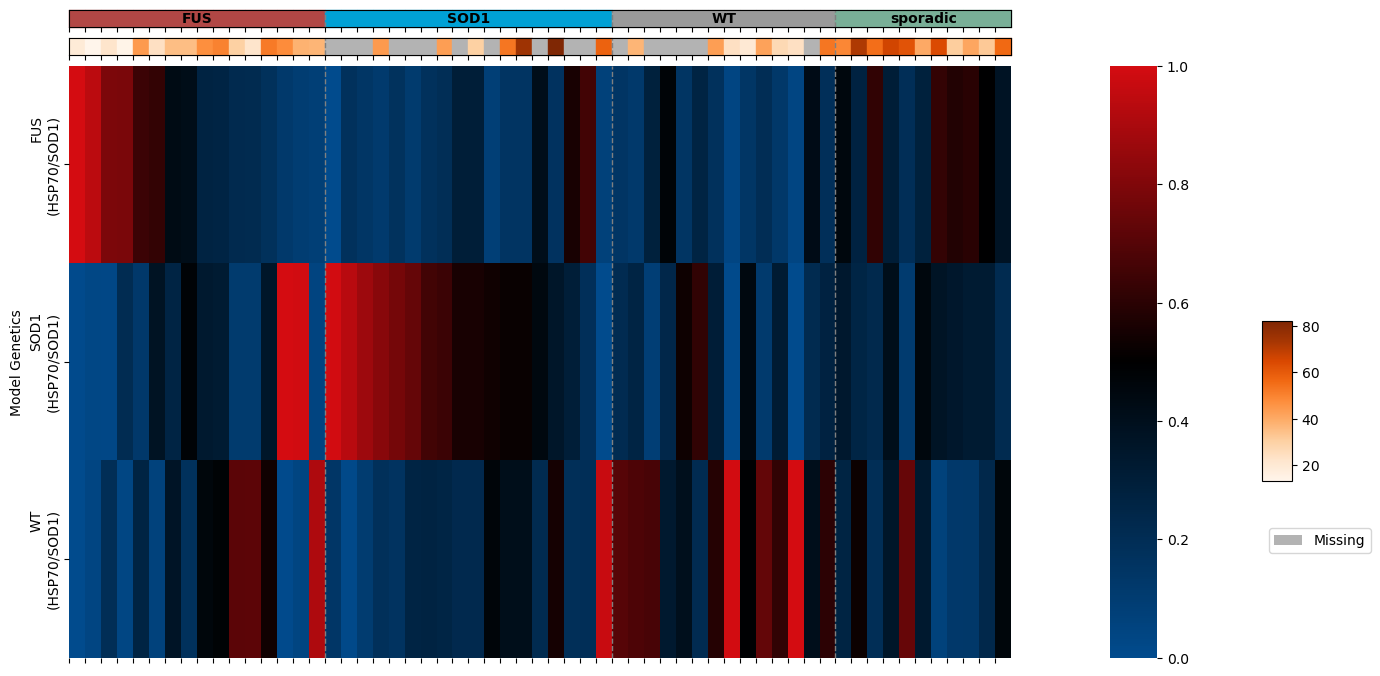

In [6]:
from maps.figures import plot_imap_heatmap

fig = plot_imap_heatmap(
    predictions=predictions,
    cellline_to_mutation=cellline_to_mutation, # maps cell lines to mutation
    class_name_map=class_name_map, # maps class indices to model genetics
    cellline_to_age=cellline_to_age, # maps cell lines to age
    row_scale=True, # rescale rows by max iMAP score
    antibodies_label=ANTIBODY[0],
    figsize=(15, 8)
)


## 2. i-MAP Scatter Plot

The `plot_imap_scatter()` function creates a scatter plot with:
- Custom positioning based on mutation/model matching
- Alpha transparency for non-matching mutations
- Automatic jittering for better visualization

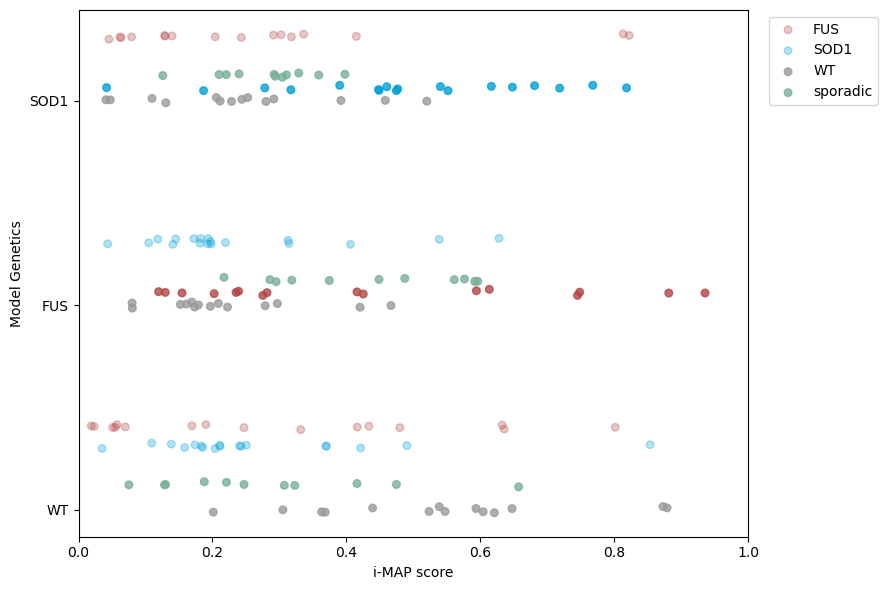

In [7]:
from maps.figures import plot_imap_scatter

fig = plot_imap_scatter(
    predictions=predictions,
    cellline_to_mutation=cellline_to_mutation,
    class_name_map=class_name_map,
    figsize=(10, 6)
)


## 3. Stacked Bar Plots

The `plot_imap_barplot()` function creates stacked bar plots showing:
- Class probabilities for each cell line
- Separate plots for each true class
- Optional sporadic sample handling
- Integration with conformal prediction sets

In [8]:
from maps.figures import plot_imap_barplot

# First, let's generate conformal prediction sets (see below for details)
from maps.utils import conformal_prediction_sets_cross

prediction_sets = conformal_prediction_sets_cross(
    predictions,
    quantile=0.9,
    random_state=42
)

print("Prediction sets generated:")
print(prediction_sets.head())

Prediction sets generated:
  CellLines  True PredictionSet  Covered
0      ALS1   0.0        [0, 1]     True
1     ALS15   0.0     [0, 1, 2]     True
2     ALS26   2.0     [0, 1, 2]     True
3     ALS30   2.0        [1, 2]     True
4     ALS31   2.0           [2]     True


Generated 4 bar plots (one per true class)


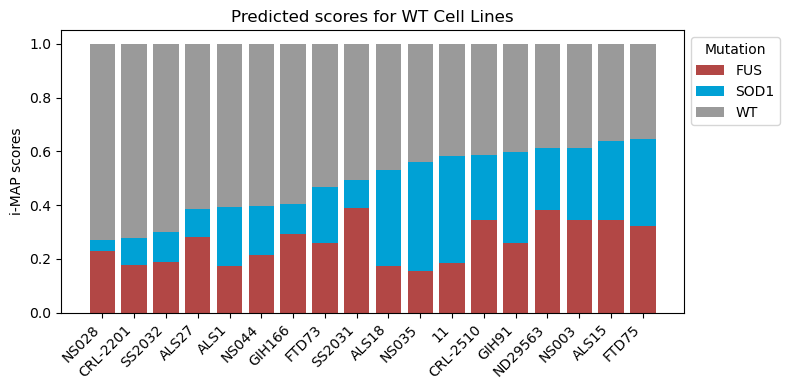

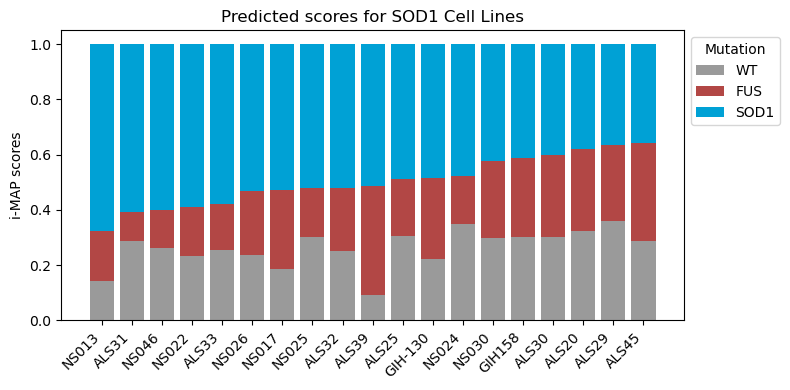

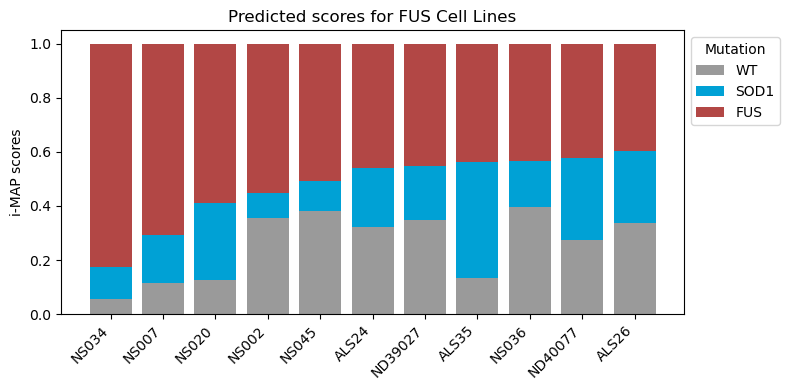

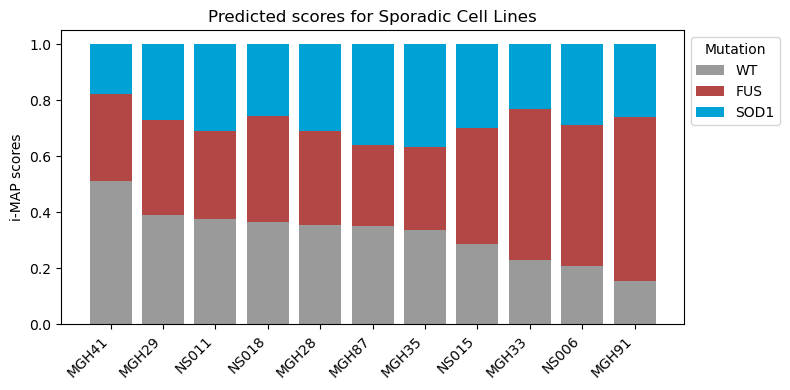

In [40]:
# Create stacked bar plots
figures = plot_imap_barplot(
    predictions=predictions,
    class_name_map=class_name_map,
    cellline_to_mutation=cellline_to_mutation,
    prediction_sets=prediction_sets,
    figsize_per_cellline=0.4,
    show_sporadic=True
)

print(f"Generated {len(figures)} bar plots (one per true class)")

# Utility Functions

## 1. Conformal Prediction Sets

Generate prediction sets with calibrated coverage guarantees using conformal prediction.

In [9]:
from maps.utils import conformal_prediction_sets_cross

# Cross-conformal prediction (splits data into two groups)
prediction_sets_cross = conformal_prediction_sets_cross(
    predictions,
    quantile=0.75,
    random_state=42
)

print("Cross-conformal prediction sets:")
print(prediction_sets_cross)
print(f"\nCoverage: {prediction_sets_cross['Covered'].mean():.2%}")
print(f"Average set size: {prediction_sets_cross['PredictionSet'].apply(len).mean():.2f}")

Cross-conformal prediction sets:
   CellLines  True PredictionSet  Covered
0       ALS1   0.0        [0, 1]     True
1      ALS15   0.0        [0, 1]     True
2      ALS26   2.0        [1, 2]     True
3      ALS30   2.0           [2]     True
4      ALS31   2.0           [2]     True
5      ALS35   2.0        [1, 2]     True
6   CRL-2510   0.0        [0, 2]     True
7      FTD75   0.0        [0, 2]     True
8    GIH-130   1.0           [2]    False
9     GIH158   0.0        [0, 2]     True
10    GIH166   0.0           [0]     True
11     GIH91   0.0        [0, 2]     True
12     MGH35   0.0     [0, 1, 2]     True
13     MGH41   0.0           [0]     True
14   ND29563   1.0           [0]    False
15   ND39027   1.0     [0, 1, 2]     True
16     NS002   1.0           [1]     True
17     NS006   0.0        [1, 2]    False
18     NS007   1.0           [1]     True
19     NS011   0.0        [1, 2]    False
20     NS013   2.0        [1, 2]     True
21     NS015   0.0        [1, 2]    False
2

### Conformal Prediction at Multiple Confidence Levels

In [10]:
from maps.utils import compute_conformal_threshold_grid

# Compute thresholds for multiple confidence levels
thresholds = compute_conformal_threshold_grid(
    predictions,
    quantiles=[0.75, 0.85, 0.9, 0.95]
)

print("Conformal thresholds at different confidence levels:")
for quantile, threshold in thresholds.items():
    print(f"  {quantile:.0%} confidence: threshold = {threshold:.4f}")

Conformal thresholds at different confidence levels:
  75% confidence: threshold = 0.7548
  85% confidence: threshold = 0.8124
  90% confidence: threshold = 0.8701
  95% confidence: threshold = 0.8819


### Visualize Conformal Regions in Probability Space

For low-dimensional cases, we can visualize the conformal prediction regions.

**Interpretation**: Each region represents the set of probability vectors where a specific class would be included in the prediction set at a given confidence level. For example, the 90% confidence region for class "WT" includes all probability vectors where P(WT) is high enough that the class would be in the 90% prediction set (i.e., P(WT) >= 1 - threshold).

In [11]:
from maps.utils import generate_conformal_regions
import matplotlib.pyplot as plt

# Generate conformal regions (note: this can be slow for fine grids)
# Using a coarser grid for demonstration
regions = generate_conformal_regions(
    predictions,
    quantiles=[0.75, 0.9],
    n_classes=len(class_name_map),
    grid_step=0.05  # Coarser grid for speed
)

print(f"Generated conformal regions for {len(regions)} (quantile, class) pairs")
print(f"Example: Region for 90% confidence, class 0 has {len(regions[(0.9, 0)])} probability vectors")

Generated conformal regions for 6 (quantile, class) pairs
Example: Region for 90% confidence, class 0 has 171 probability vectors


## 4. PCA Visualization with Conformal Regions

Project i-MAP scores into PCA space and visualize conformal prediction regions as convex hulls.

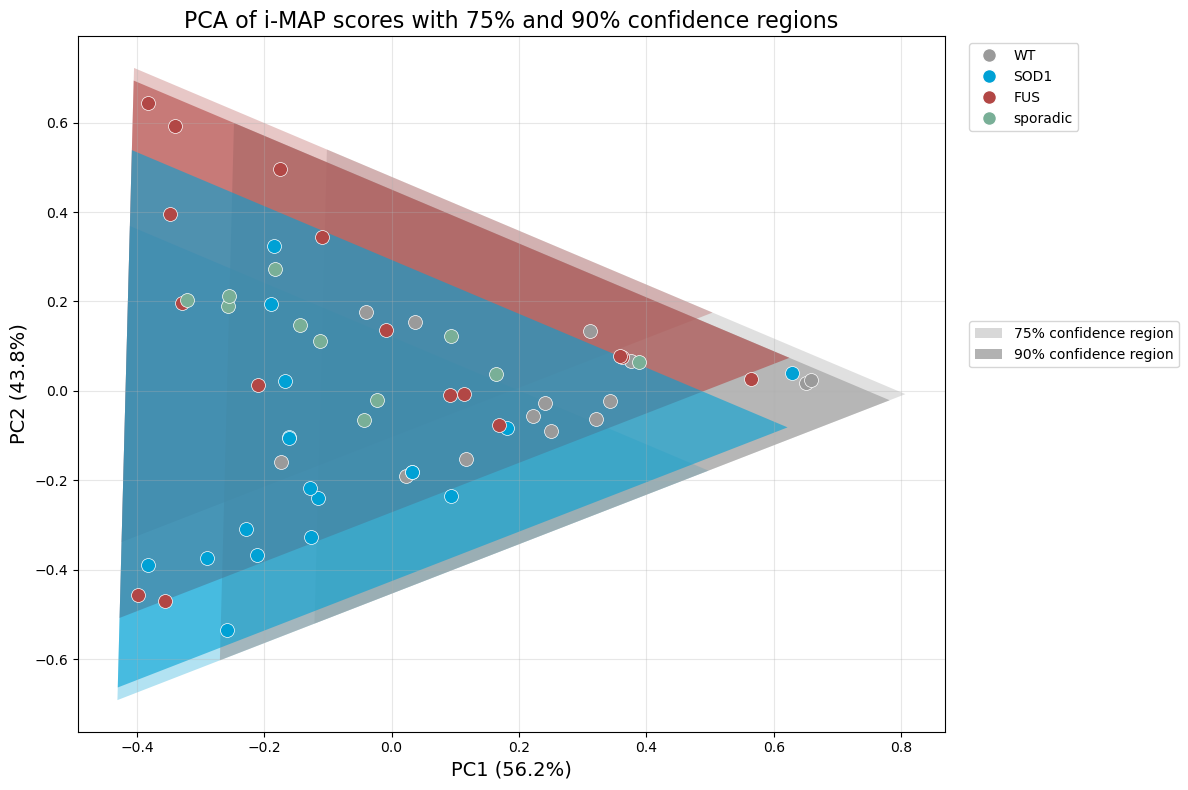

In [12]:
from maps.figures import plot_imap_pca

# Create PCA plot with conformal regions
fig = plot_imap_pca(
    predictions=predictions,
    class_name_map=class_name_map,
    cellline_to_mutation=cellline_to_mutation,
    conformal_regions=regions,
    figsize=(12, 8),
    title='PCA of i-MAP scores with 75% and 90% confidence regions'
)

plt.show()

## 2. Count Correction Functions

Correct i-MAP scores for cell count effects using linear regression. 

**For multiclass data:** The `correct_imap_scores()` function accepts a list of score columns (e.g., `['Class_0', 'Class_1', 'Class_2']`). It regresses each class independently on cell counts and mutations, evaluates at the reference count, then applies softmax to renormalize the corrected scores into valid probabilities that sum to 1.

**For single score:** Pass a single column name for backward compatibility (returns 'Score_corrected' column).

In [13]:
# First, we need to add cell count information to our predictions
# Get cell counts from screen metadata if available
screen_data = []
screen.load(antibody=ANTIBODY)

for ab in ANTIBODY:
    screen_data.append(screen.metadata[ab].to_pandas())

screen_data = pd.concat(screen_data, ignore_index=True)

# Check if CellLines column exists
if "CellLines" not in screen_data.columns:
    print("Warning: 'CellLines' column not found in screen metadata.")
    print("Available columns:", screen_data.columns.tolist())
    print("\nSkipping count correction - no cell count data available.")
    predictions_with_counts = None
else:
    cellline_counts = (
        screen_data.groupby("CellLines")["NCells"]
        .mean()
        .reset_index()
    )
    
    # Merge with predictions
    predictions_with_counts = pd.merge(
        predictions,
        cellline_counts,
        on="CellLines",
        how="left"
    )
    
    print("Predictions with cell counts:")
    print(predictions_with_counts.head())


Predictions with cell counts:
  CellLines   Class_0   Class_1   Class_2  True      NCells
0        11  0.604150  0.152017  0.243833   0.0  759.500000
1      ALS1  0.593370  0.296908  0.109722   0.0  579.416667
2     ALS15  0.305115  0.466485  0.228400   0.0  695.583333
3     ALS18  0.620854  0.173330  0.205817   0.0  687.333333
4     ALS20  0.362985  0.178960  0.458055   0.0  585.000000


In [14]:
from maps.utils import correct_imap_scores

# Only run correction if we have count data
if predictions_with_counts is not None:
    # Correct scores for cell count effects using multiclass softmax approach
    # Regress each class independently, then renormalize with softmax
    class_cols = [f'Class_{i}' for i in range(len(class_name_map))]
    
    predictions_corrected, models = correct_imap_scores(
        predictions_with_counts,
        cellline_to_mutation=cellline_to_mutation,
        cell_count_col='NCells',
        score_col=class_cols,  # Pass list of all class columns
        reference_count=1000
    )
    
    print("Count correction models fitted for each class")
    print(f"Corrected probability columns: {[f'{col}_corrected' for col in class_cols]}")
    print("\nExample corrected probabilities:")
    display_cols = ['CellLines', 'NCells'] + class_cols + [f'{col}_corrected' for col in class_cols]
    print(predictions_corrected[display_cols].head())
else:
    print("Skipping count correction - no cell count data available.")
    predictions_corrected = None


Count correction models fitted for each class
Corrected probability columns: ['Class_0_corrected', 'Class_1_corrected', 'Class_2_corrected']

Example corrected probabilities:
  CellLines      NCells   Class_0   Class_1   Class_2  Class_0_corrected  \
0        11  759.500000  0.604150  0.152017  0.243833           0.493107   
1      ALS1  579.416667  0.593370  0.296908  0.109722           0.539953   
2     ALS15  695.583333  0.305115  0.466485  0.228400           0.401055   
3     ALS18  687.333333  0.620854  0.173330  0.205817           0.519526   
4     ALS20  585.000000  0.362985  0.178960  0.458055           0.445044   

   Class_1_corrected  Class_2_corrected  
0           0.226737           0.280156  
1           0.227469           0.232578  
2           0.312420           0.286525  
3           0.217702           0.262772  
4           0.211385           0.343571  


# Feature Importance Analysis

## Integrated Gradients

**What are Integrated Gradients?**

Integrated gradients (IG) is an attribution method that explains model predictions by measuring how much each input feature contributes to the model's output. Intuitively, IG answers the question: "How would the model's prediction change if we gradually morphed a baseline input (e.g., all zeros) into the actual input?" By integrating the gradients along this path, we get a measure of each feature's importance that satisfies desirable properties like completeness (attributions sum to the prediction difference from baseline).

**Key Implementation Details:**

1. **Sample-Level Attribution**: Integrated gradients are computed at the single-cell level. Since each cell line contains multiple cells, we average the IG values across all cells within a cell line to obtain cell-line-level feature importance scores.

2. **Class-Specific Interpretation**: IG is computed separately for each class. The IG value for a feature with respect to class $k$ tells us how much that feature contributes to increasing (positive IG) or decreasing (negative IG) the model's predicted probability for class $k$. High absolute IG values indicate features that strongly influence the model's prediction for that specific class.

3. **Model-Specific Results**: When using cross-validation or leave-one-out cross-validation (LOOCV), each fold produces a distinct model with its own set of gradients. The IG values shown here are computed from a single model (the first split). Different models may produce somewhat different feature importance rankings, though important features tend to be consistent across folds.

For multiclass models, we compute integrated gradients for each class separately to understand class-specific feature contributions.

In [47]:
from maps.multiantibody.data_loaders import create_multiantibody_dataloader

screen.preprocess()
map_response["Mutations"]["sporadic"] = 0 # add sporadic key back

# Check if we have a fitted PyTorch model
fitted_models = map_analysis.fitted['fitted']

# Use the first fitted model for demonstration
model_for_ig = fitted_models[0]

# Get scalers from the first fold
scalers = map_analysis.fitted.get('scalers', [None])[0]

# Create dataloader for evaluation
# We'll compute IG for all cell lines in the test set
eval_dataloader = create_multiantibody_dataloader(
    screen,
    response="Mutations",
    grouping="CellLines",
    response_map=map_response,
    mode="eval",
    n_cells=100,
    shuffle=False,
    scale=True,
    scalers=scalers
)

Preprocessing complete


In [ ]:
from maps.model_utils import integrated_gradients

# Compute integrated gradients for all classes
target_classes = list(range(len(class_name_map)))

integrated_grads_df = integrated_gradients(
    dataloader=eval_dataloader,
    target_class=target_classes,  # Compute for all classes
    fit=model_for_ig,
    n_steps=50,
    baseline='zeros'
)

print(f"\\nIntegrated gradients computed successfully!")
print(f"\\nDataFrame shape: {integrated_grads_df.shape}")
print(f"Columns: CellLine, Class, + {integrated_grads_df.shape[1] - 2} features")
print(f"\\nFirst few rows:")
print(integrated_grads_df.head(10))
print(f"\\nUnique cell lines: {integrated_grads_df['CellLine'].nunique()}")
print(f"Classes per cell line: {integrated_grads_df['Class'].nunique()}")

NameError: name 'integrated_gradients' is not defined